In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral as spectral

In [15]:
class SoundWaves:
    
    def __init__(self, domain, u, ux, p0):
        self.u = u
        self.ux = ux
        self.domain = domain
        self.dtype = dtype = u.dtype
        self.dudx = spectral.Field(domain, dtype=dtype)
        self.u_RHS = spectral.Field(domain, dtype=dtype)
        self.ux_RHS = spectral.Field(domain, dtype=dtype)
        
        self.problem = spectral.InitialValueProblem(domain, [u, ux], [self.u_RHS, self.ux_RHS],
                                                    num_BCs=2, dtype=dtype)
        
        self.p0 = p0
        
        pr = self.problem.pencils[0]
        
        self.N = N = domain.bases[0].N
        Z = np.zeros((N, N))
        
        diag =  np.arange(N-1)+1
        self.D = D = (2/3) * sparse.diags(diag, offsets=1)

        diag0 = np.ones(N)/2
        diag0[0] = 1
        diag2 = -np.ones(N-2)/2
        self.C = C = sparse.diags((diag0, diag2), offsets=(0,2))
        
        M = sparse.csr_matrix((2*N+2,2*N+2))
        M[0:N, 0:N] = C
        M[N:2*N, N:2*N] = C
        pr.M = M
        
        # L matrix
        BC_rows = np.zeros((2, 2*N))
        i = np.arange(N)
        BC_rows[0, :N] = (-1)**i
        BC_rows[1, :N] = (+1)**i

        cols = np.zeros((2*N,2))
        cols[  N-1, 0] = 1
        cols[2*N-1, 1] = 1
        corner = np.zeros((2,2))

        Z = np.zeros((N, N))
        L = sparse.bmat([[Z, D],
                         [D, Z]])
        L = sparse.bmat([[      L,   cols],
                         [BC_rows, corner]])
        L = L.tocsr()
        pr.L = L
        self.t = 0
        
    def evolve(self, timestepper, dt, num_steps):
        ts = timestepper(self.problem)
        u = self.u
        ux = self.ux
        ux_RHS = self.ux_RHS
        dudx = self.dudx
        
        p0 = self.p0
        
        
        for i in range(num_steps):
            u.require_coeff_space()
            ux.require_coeff_space()       
            
            dudx.require_coeff_space()
            dudx_temp = self.D @ u.data
            
            dudx.data = spla.spsolve(self.C, dudx_temp)
            
            ux_RHS.require_grid_space()
            p0.require_grid_space()

            dudx.require_grid_space()

            ux_RHS.data = (1 - p0.data) * dudx.data
            ux_RHS.require_coeff_space()
            ux_RHS.data = self.C @ ux_RHS.data
            
            
            ts.step(dt, [0, 0])
            self.t += dt

C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


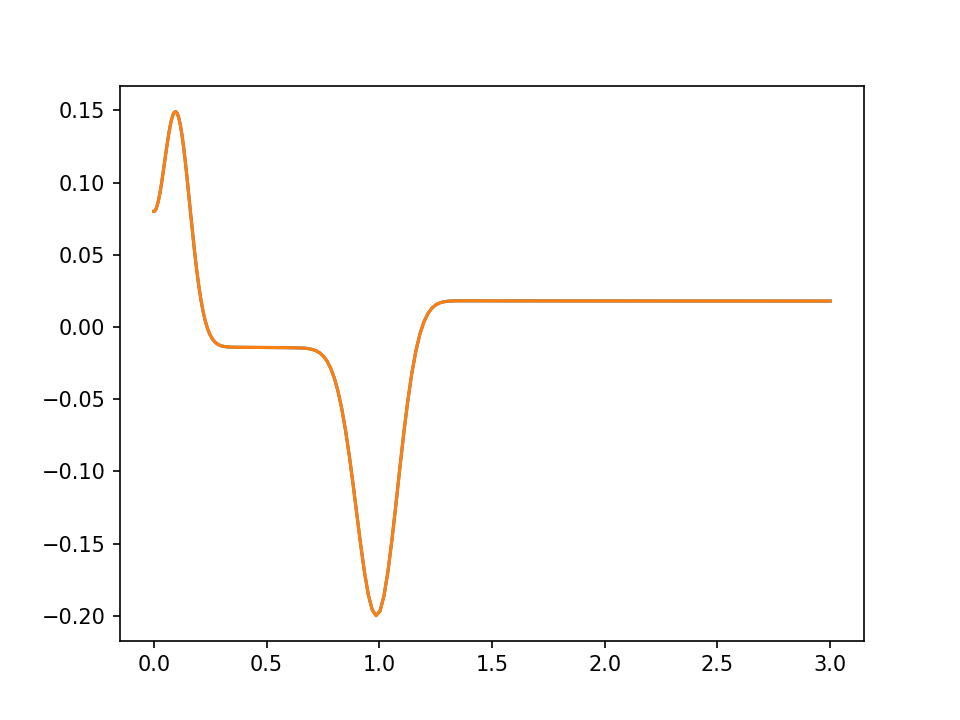

2.414700384090196e-13


In [17]:
N = 128
dtype = np.float64
x_basis = spectral.Chebyshev(N, interval=(0, 3))
domain = spectral.Domain([x_basis])
x = x_basis.grid()
u = spectral.Field(domain, dtype=dtype)
p = spectral.Field(domain, dtype=dtype)
p0 = spectral.Field(domain, dtype=dtype)
    
u.require_grid_space()
u.data = np.exp(-(x-0.5)**2/0.01)

p0.require_grid_space()
p0.data = 0.1 + x**2/9

waves = SoundWaves(domain, u, p, p0)


waves.evolve(spectral.SBDF2, 2e-3, 5000)

p.require_coeff_space()
p.require_grid_space(scales=256//N)
u.require_grid_space(scales=256//N)

sol = np.loadtxt('waves_variable.dat')
    
xplotbasis = spectral.Chebyshev(256, interval=(0, 3))
xplot = xplotbasis.grid()
plt.figure()
plt.plot(xplot, p.data)
plt.plot(xplot, sol)

error = np.max(np.abs(sol - p.data))
    
print(error)


